In this script I am going to train a ML model to classificate exotic fruits

## Loading data and checking missing values

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import  StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp,skewtest

In [2]:
df = pd.read_csv("fruits.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Frutto                 500 non-null    object 
 1   Peso (g)               500 non-null    float64
 2   Diametro medio (mm)    500 non-null    float64
 3   Lunghezza media (mm)   500 non-null    float64
 4   Durezza buccia (1-10)  500 non-null    float64
 5   Dolcezza (1-10)        500 non-null    float64
dtypes: float64(5), object(1)
memory usage: 23.6+ KB


In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Peso (g),500.0,47.31344,26.768797,8.57,24.7975,42.380,68.0800,111.21
Diametro medio (mm),500.0,86.57310,64.293403,7.53,50.5100,70.450,88.8525,299.89
Lunghezza media (mm),500.0,5.29862,2.641993,1.15,2.6725,5.670,7.4550,11.14
Durezza buccia (1-10),500.0,7.43764,1.812548,3.07,6.1525,7.340,8.6150,13.72
Dolcezza (1-10),500.0,3.59322,1.264899,1.25,2.5700,3.535,4.4650,6.95


In [5]:
df.isna().sum()

Frutto                   0
Peso (g)                 0
Diametro medio (mm)      0
Lunghezza media (mm)     0
Durezza buccia (1-10)    0
Dolcezza (1-10)          0
dtype: int64

No missing values, so no need in managing them

## EDA

### Balanced target

<Axes: xlabel='Frutto'>

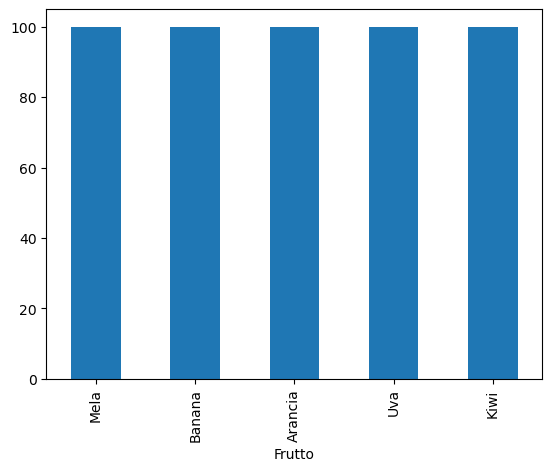

In [6]:
df["Frutto"].value_counts().plot(kind='bar')

Dataset perfectly balanced, accuracy could be a good metric in this case

### Pairplot

<Figure size 640x480 with 0 Axes>

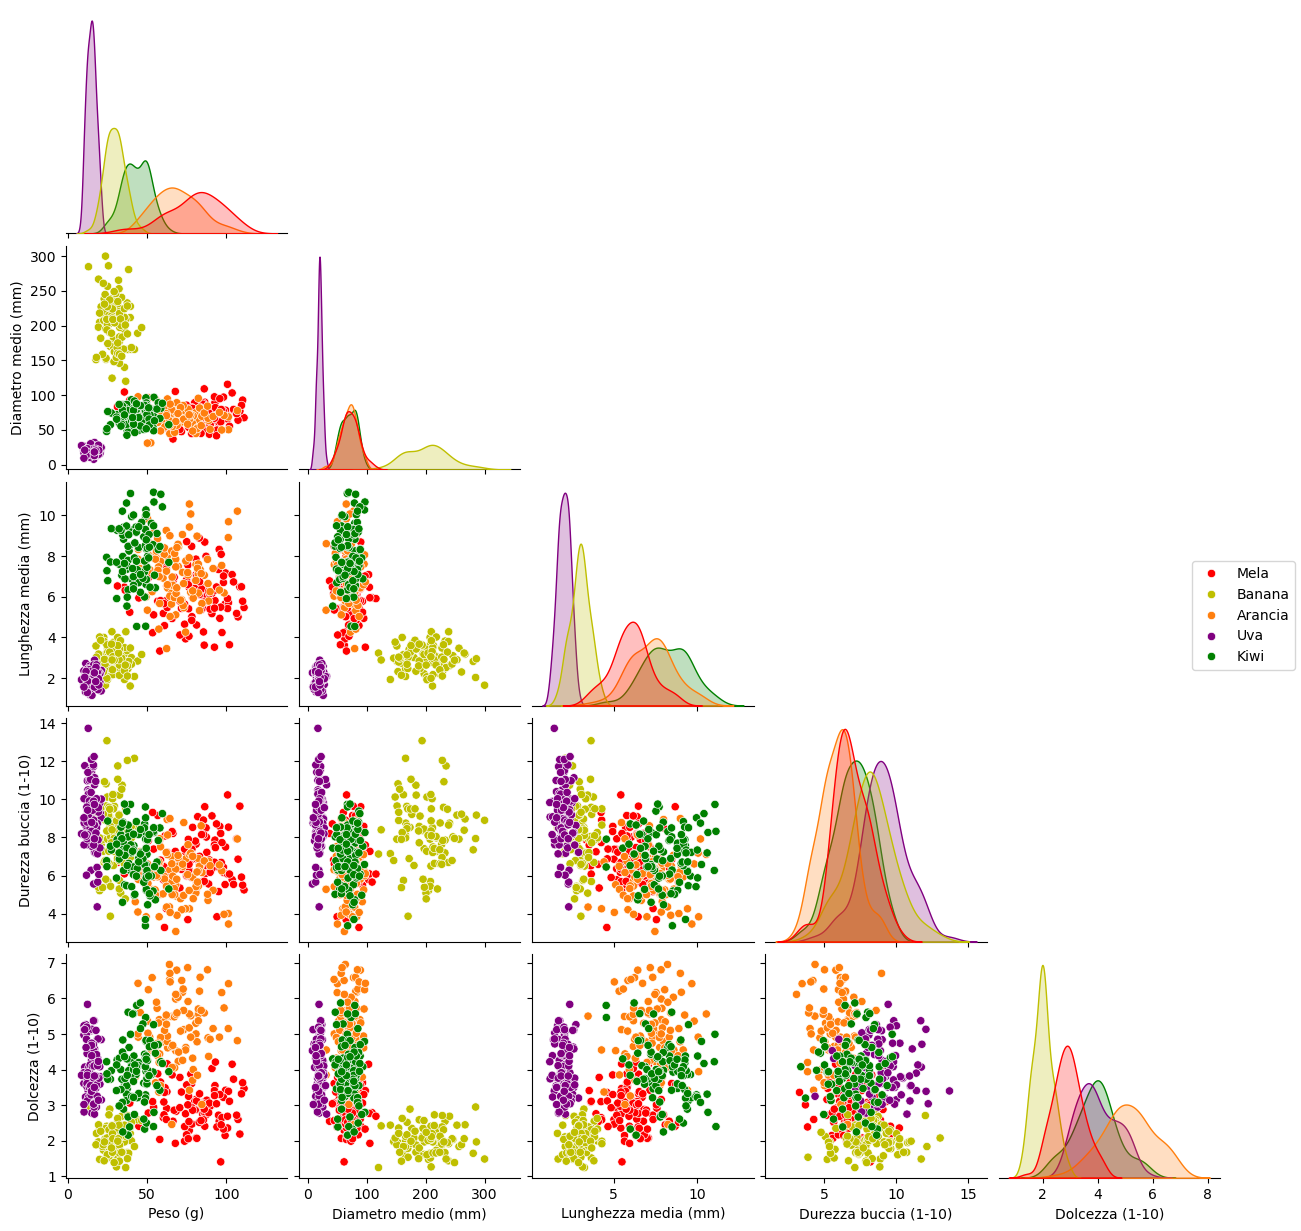

In [7]:
plt.figure()
df2 = df.copy()
fruits = list(df2.Frutto.unique())
color = {"Arancia":"C1","Banana":"y","Kiwi":"g","Mela":"r","Uva":"purple"}
tmap = {k: v for k, v in zip(fruits, np.arange(5))}
cmap = {k: v for k, v in zip(fruits, list(map(color.get, fruits)) )}
palette = list(map(cmap.get, fruits))
df2.Frutto = df2.Frutto.map(tmap)

g = sns.pairplot(df2,hue='Frutto',corner=True,vars = df2.columns[1:6],palette=palette)
g.legend.remove()
handles = g._legend_data.values()
labels = g._legend_data.keys()
g.figure.legend(handles=handles, labels=fruits, loc='center right')
plt.show()
del df2

Here can be seen a limit of this data: the superpositioning of orange, apples and kiwi distributions. Bananas diameter and length seems to be swapped. In this case a banana could be seen this way too, provided they keep quite distinguished from the other fruits.

### Distrubution comparision

In [8]:
from itertools import combinations

for i in fruits:
    globals()[f'df_{i}'] = df[df['Frutto'] == i]

def ks_2samp_pairs(pair, p_thresh = .05):
    ret = []
    f1, f2 = pair
    for col in df.columns[1:]:
        statistic, p_value = ks_2samp(globals()[f'df_{f1}'][col], globals()[f'df_{f2}'][col])
        if p_value >= p_thresh:
           print(f"{col} {f1} vs {f2}  p_value {p_value}\n")


pairs = combinations(fruits, 2)
for pair in pairs:
    ks_2samp_pairs(pair)


Diametro medio (mm) Mela vs Arancia  p_value 0.9084105017744525

Diametro medio (mm) Mela vs Kiwi  p_value 0.5830090612540064

Durezza buccia (1-10) Mela vs Kiwi  p_value 0.36818778606286096

Diametro medio (mm) Arancia vs Kiwi  p_value 0.8154147124661313

Dolcezza (1-10) Uva vs Kiwi  p_value 0.5830090612540064



Diameter alone cannot distinguish between apples, kiwis, and oranges. Similarly, skin hardness cannot differentiate between apples and kiwis, and sweetness alone does not distinguish between grapples and kiwis. Given these limitations, it is unlikely that the model will learn much from these comparisons.

### Impiled histograms

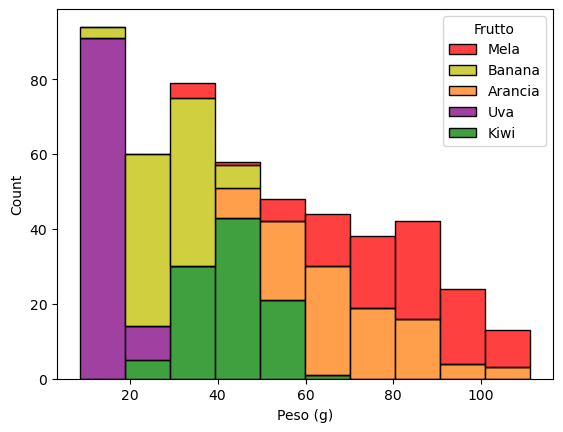

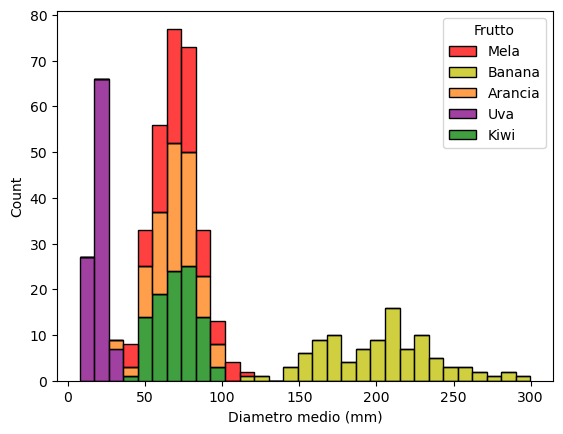

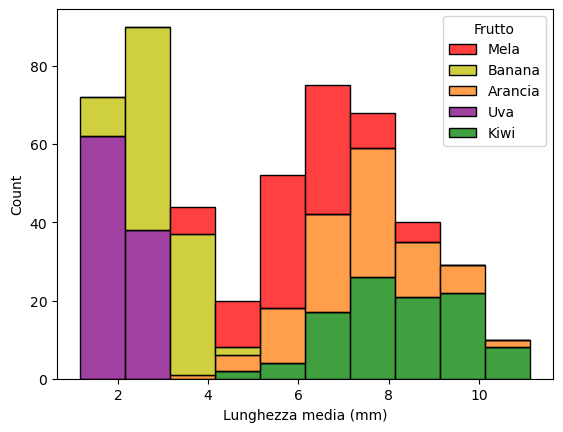

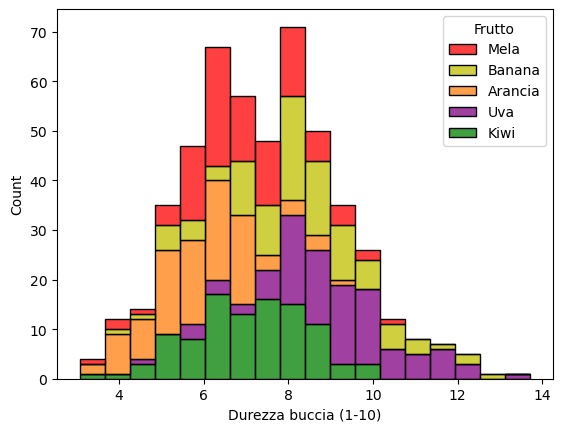

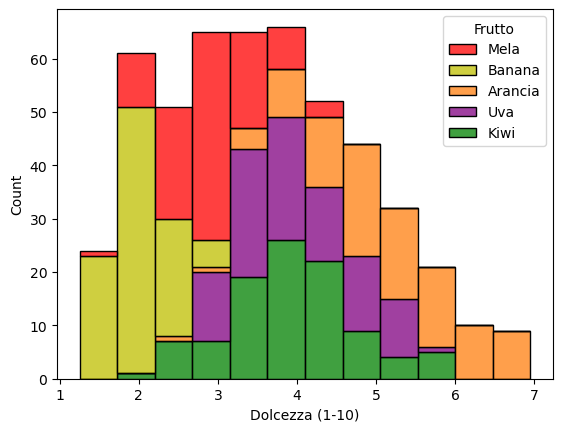

In [9]:
for i in np.arange(len(df.columns[1:])):
    plt.figure()
    sns.histplot(data = df,x = df.columns[i+1],hue='Frutto',multiple='stack',palette=palette)
    plt.show()

These histograms help viewing whole distributions of features, but hardly a Gaussian distribution can be seen. Since KNN suffers non-Gaussian distributions, we need a power transform. We could also observe that there are some zones of distributions where a fruit is likely: model will learn by this information.

### Correlation matrix

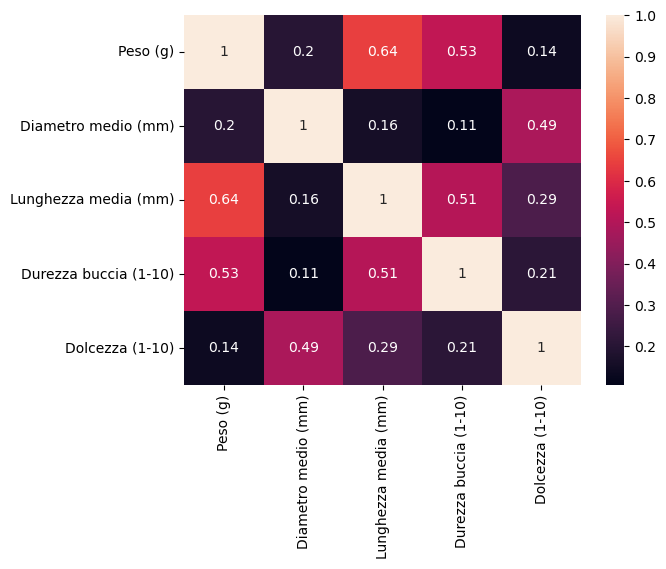

In [10]:
plt.figure()
sns.heatmap(df.corr(numeric_only=True,method='spearman').abs(),annot=True)
plt.show()

There is no such huge correlation between features that would lead me to reject any

Now we know what kind of data are we dealing with: non-Gaussian distributions and three fruits hard to distinguish one another.

## Preprocessing 

Despite having a categorical target, One hot encoding isn't needed because KNN returns the most frequent value among the neighbourhood.

In [11]:
ss = StandardScaler()
X = pd.DataFrame(ss.fit_transform(df[df.columns[1:]]),columns=df.columns[1:])
y = df["Frutto"]

KNN works optimally with Gaussian distribution, so we will try transforming our features with power transform

In [12]:
skewtest(X).pvalue

array([6.24353075e-05, 1.50985768e-20, 2.79956974e-01, 5.72439321e-03,
       2.11930225e-03])

Low pvalues, asymmetric distributions

In [13]:
pt = PowerTransformer()
X2 = pt.fit_transform(X)
skewtest(X2).pvalue

array([0.43054528, 0.68919661, 0.61008409, 0.89861816, 0.67111187])

In [14]:
X3 = pt.fit_transform(X2)
skewtest(X3).pvalue

array([0.8614665 , 0.91736713, 0.71884366, 0.93131126, 0.84949384])

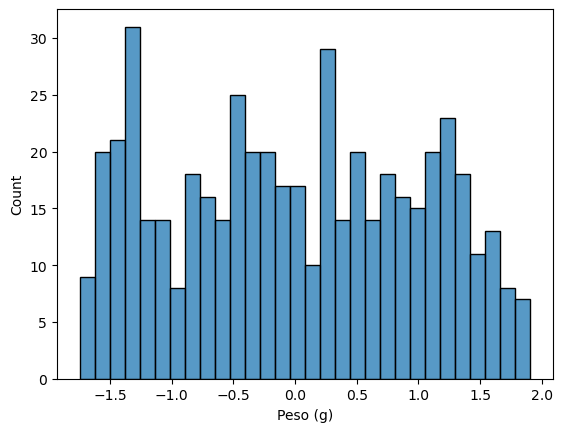

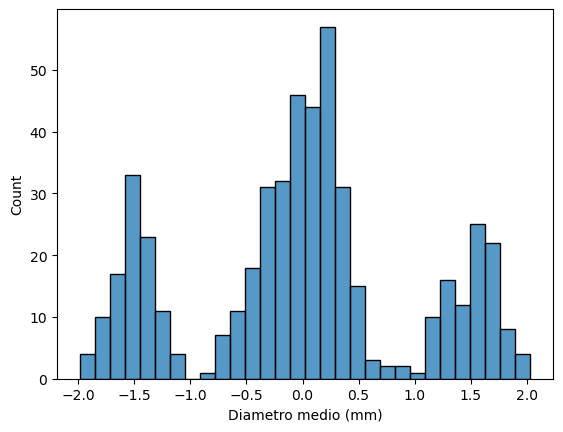

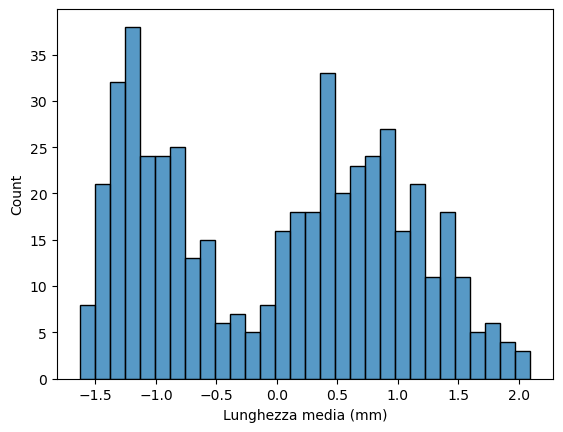

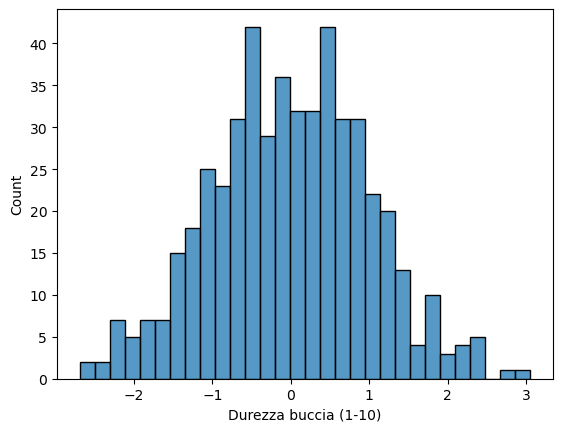

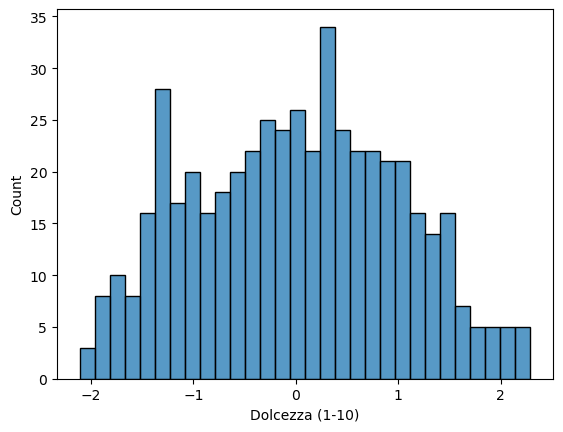

In [15]:
for i in X.columns:
    plt.figure()
    sns.histplot(data = pd.DataFrame(data=X3,columns=X.columns),x = i,bins=30)
    plt.show()

Our pvalues has strongly increased, so distributions are more symmetric, though not necessarily Gaussian. However, this is still a positive outcome, as achieving greater symmetry brings us closer to a Gaussian distribution.

In the end, we have at least symmetric features distributions, low dimensionality data, no apparent outliers: data are ready to feed a KNN model

## Model

It is required creating a KNN model. This could be a good choice since it is simple, flexible and there is little data. I don't mind interpretation.
I am going to implement K-Fold to have a custom cross correlation since I am interested in knowing accuracy score for both train and validate set.

In [16]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
X3 = pd.DataFrame(data=X3,columns=X.columns)
for k in np.arange(1,10):
    
    knn = KNeighborsClassifier(n_neighbors=k,n_jobs=-1)
    print(f"K = {k}")
    test_scores = []
    train_scores = []
    for train_idx,test_idx in kf.split(X):
    
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        knn.fit(X_train, y_train)
        y_train_pred = knn.predict(X_train)
        y_test_pred = knn.predict(X_test)
        
        train_scores.append(accuracy_score(y_train, y_train_pred))
        test_scores.append(accuracy_score(y_test, y_test_pred))

    print(f"Cross-validation score train: {train_scores}, mean: {np.mean(train_scores):.3f}")
    print(f"Cross-validation score test: {test_scores}, mean: {np.mean(test_scores):.3f}")
    

K = 1
Cross-validation score train: [1.0, 1.0, 1.0, 1.0, 1.0], mean: 1.000
Cross-validation score test: [0.88, 0.93, 0.92, 0.93, 0.89], mean: 0.910
K = 2
Cross-validation score train: [0.965, 0.95, 0.9475, 0.9525, 0.955], mean: 0.954
Cross-validation score test: [0.85, 0.9, 0.88, 0.9, 0.86], mean: 0.878
K = 3
Cross-validation score train: [0.9625, 0.9475, 0.95, 0.96, 0.96], mean: 0.956
Cross-validation score test: [0.91, 0.92, 0.92, 0.93, 0.91], mean: 0.918
K = 4
Cross-validation score train: [0.945, 0.94, 0.9425, 0.945, 0.955], mean: 0.945
Cross-validation score test: [0.89, 0.91, 0.92, 0.92, 0.88], mean: 0.904
K = 5
Cross-validation score train: [0.9425, 0.9325, 0.9525, 0.9375, 0.9575], mean: 0.945
Cross-validation score test: [0.88, 0.93, 0.93, 0.92, 0.88], mean: 0.908
K = 6
Cross-validation score train: [0.9425, 0.93, 0.95, 0.9375, 0.9475], mean: 0.941
Cross-validation score test: [0.86, 0.93, 0.93, 0.91, 0.86], mean: 0.898
K = 7
Cross-validation score train: [0.945, 0.9375, 0.9575

Reckon best model has contemporary highest train and test score. A 1-accuracy score is likely a sign of overfitting, so best seems being k = 3

## Visualization

In [17]:
knn = KNeighborsClassifier(n_neighbors=3,n_jobs=-1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3,shuffle=True)
knn.fit(X_train,y_train)

y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

print(f"Accuracy train: {accuracy_score(y_train, y_train_pred):.3f}")
print(f"Accuracy test: {accuracy_score(y_test, y_test_pred):.3f}")

Accuracy train: 0.946
Accuracy test: 0.907


As expected, we have high accuracy in train and test, being train accuracy slighlty higher than test accuracy

### Confusion matrix

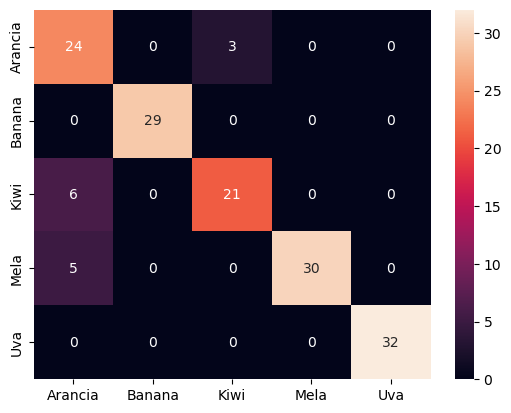

In [18]:
plt.figure()
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm,annot=True,xticklabels=np.unique(y_test),yticklabels=np.unique(y_test))
plt.show()

As we could have expected from previous analysis, oranges, apples and kiwis are often misclassified one other by the model: they are similar in size and taste.

### 2D plots vs target

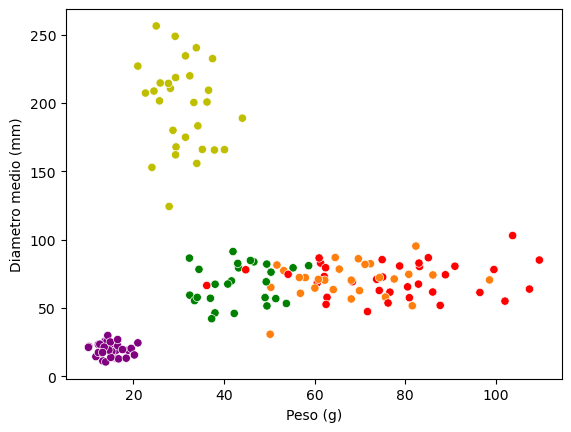

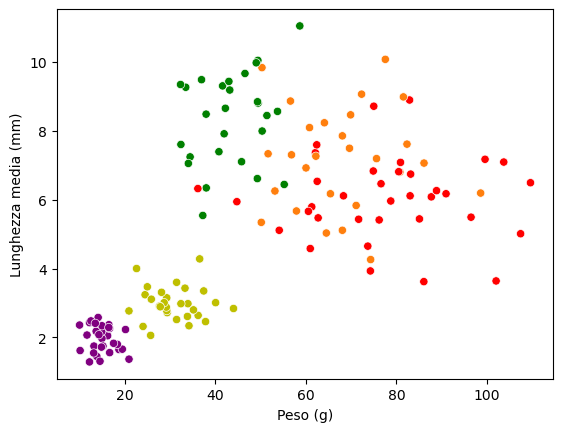

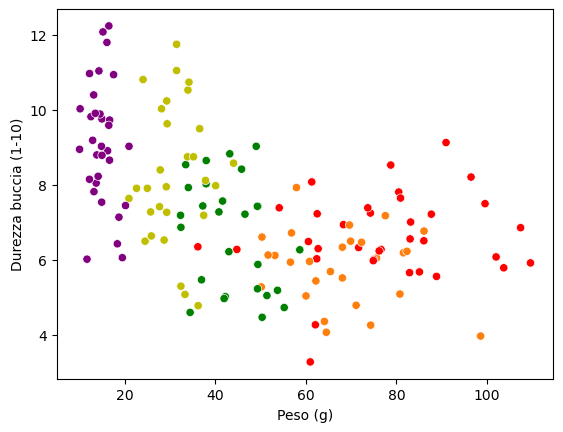

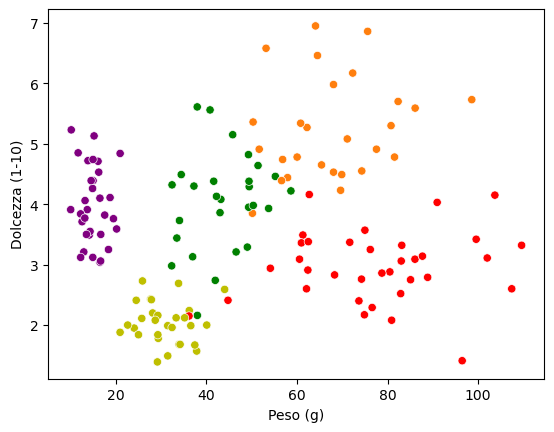

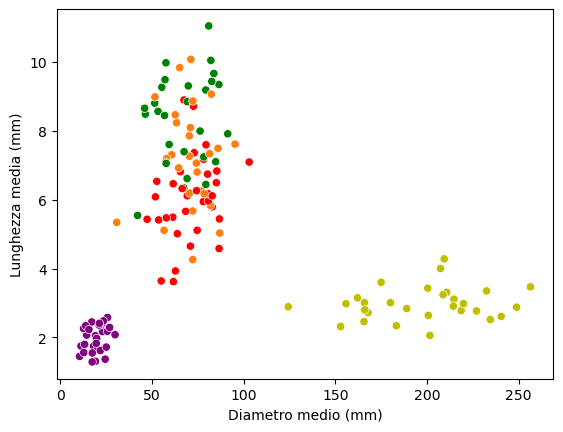

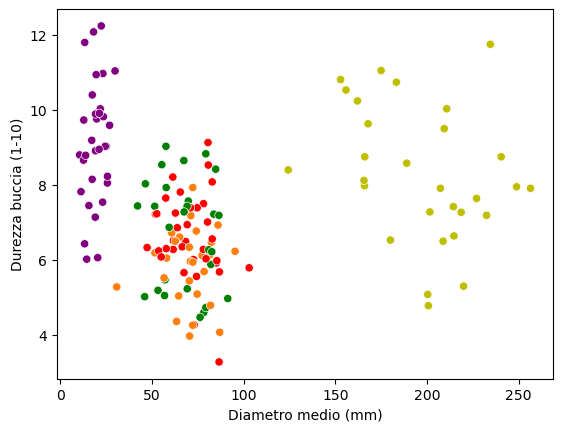

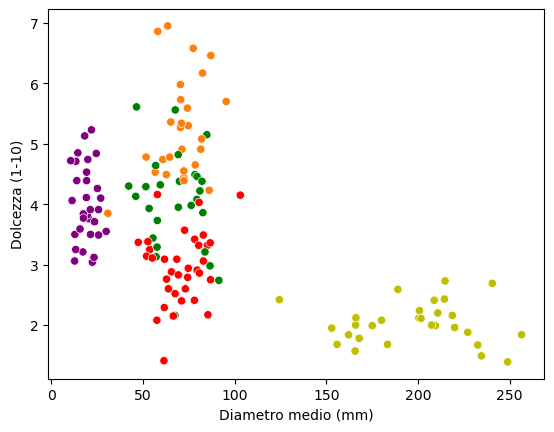

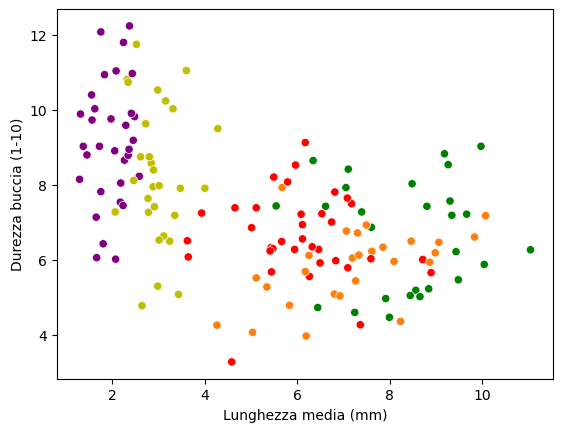

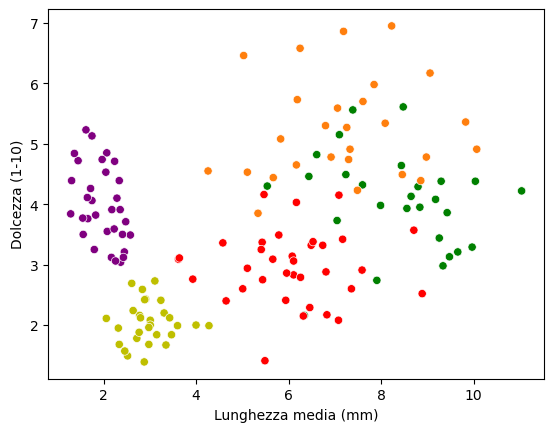

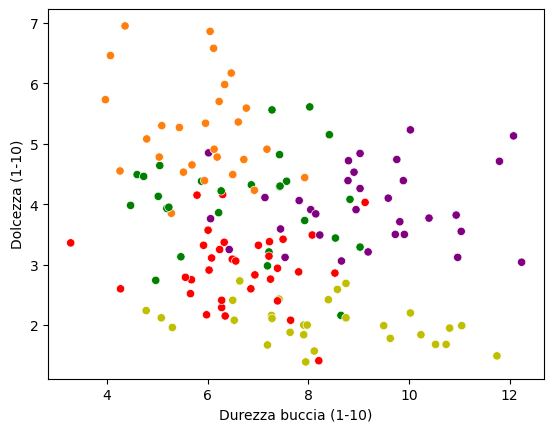

In [19]:
ycol = list(map(lambda x : color[x] ,y_test))
X_test = pd.DataFrame( ss.inverse_transform(X_test),columns=X_test.columns)
pairs = combinations(df.columns[1:], 2)
for pair in pairs:
    f1,f2 = pair
    plt.figure()
    sns.scatterplot(x=X_test[f1],y=X_test[f2],color=ycol)
    plt.show()

### 3D plot vs target

In [20]:
color_conversion = {
    'r': 'red',
    'g': 'green',
    'y': 'yellow',
    'purple': 'purple',
    'C1': 'orange', 
}

Ycol = [color_conversion.get(color, color) for color in ycol]

In [21]:
import plotly.graph_objects as go
    
triads = combinations(df.columns[1:], 3)
for triad in triads:
    f1,f2,f3 = triad

    fig = go.Figure(data=[go.Scatter3d(
        x=X_test[f1], 
        y=X_test[f2], 
        z=X_test[f3], 
        mode='markers',
        marker=dict(size=5,color=Ycol)
    )])

    fig.update_layout(
        scene=dict(
            xaxis_title=f1,
            yaxis_title=f2,
            zaxis_title=f3
        ),
        title='Fruit identification'
    )

    fig.show()

### 4D plot vs target

In [22]:
fig = go.Figure(data=[go.Scatter3d(
    x=X_test['Dolcezza (1-10)'], 
    y=X_test['Durezza buccia (1-10)'], 
    z=X_test['Lunghezza media (mm)'], 
    mode='markers',
    marker=dict(size=X_test['Peso (g)']/5,color=Ycol)
)])

fig.update_layout(
   scene=dict(
        xaxis_title='Dolcezza (1-10)',
        yaxis_title='Durezza buccia (1-10)',
        zaxis_title='Lunghezza media (mm)'
        ),
        title='Fruit identification'
    )

fig.show()

As can be seen by these plots, it is hard to find a "simple" point of view able to absolutely distinguish apples, oranges and kiwis.

## Conclusion

The model correctly guesses the fruit 90% of the time, but it struggles primarily with distinguishing between apples, oranges, and kiwis.
Bananas and grapefruits are quite easy identified. There could be some solutions:

- Introduce new features such as color or acidity to improve differentiation
- Use models less affected by non-Gaussian distributions, such as Random Forest
- Explore unsupervised clustering techniques (a kernel trick could help)
- Tune hyperparameters for the KNN algorithm

